## Settings

In [1]:
import io
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import cv2
import decord
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.datasets import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils import plot_all, plt_params, plot_per_action
from matplotlib import font_manager
import json

matplotlib.RcParams.update(plt_params())
font_path = '/mnt/c/Users/Me/AppData/Local/Microsoft/Windows/Fonts/Cairo-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
font_manager.findSystemFonts(fontext='otf')
fe = font_manager.FontEntry(fname=font_path, name='Cairo')
font_manager.fontManager.ttflist.insert(0, fe) 
matplotlib.rcParams.update(plt_params())
matplotlib.rcParams['font.family'] = 'Cairo'

In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())
item = random.choice(data)
print(item)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']
video: stu7_53.mp4
class: situp
count: 17
reps: [229, 296, 297, 362, 362, 429, 429, 497, 498, 569, 570, 638, 639, 712, 712, 778, 778, 846, 848, 913, 913, 978, 978, 1049, 1051, 1120, 1121, 1190, 1191, 1260, 1261, 1325, 1326, 1394]
fps: 29.924


In [3]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


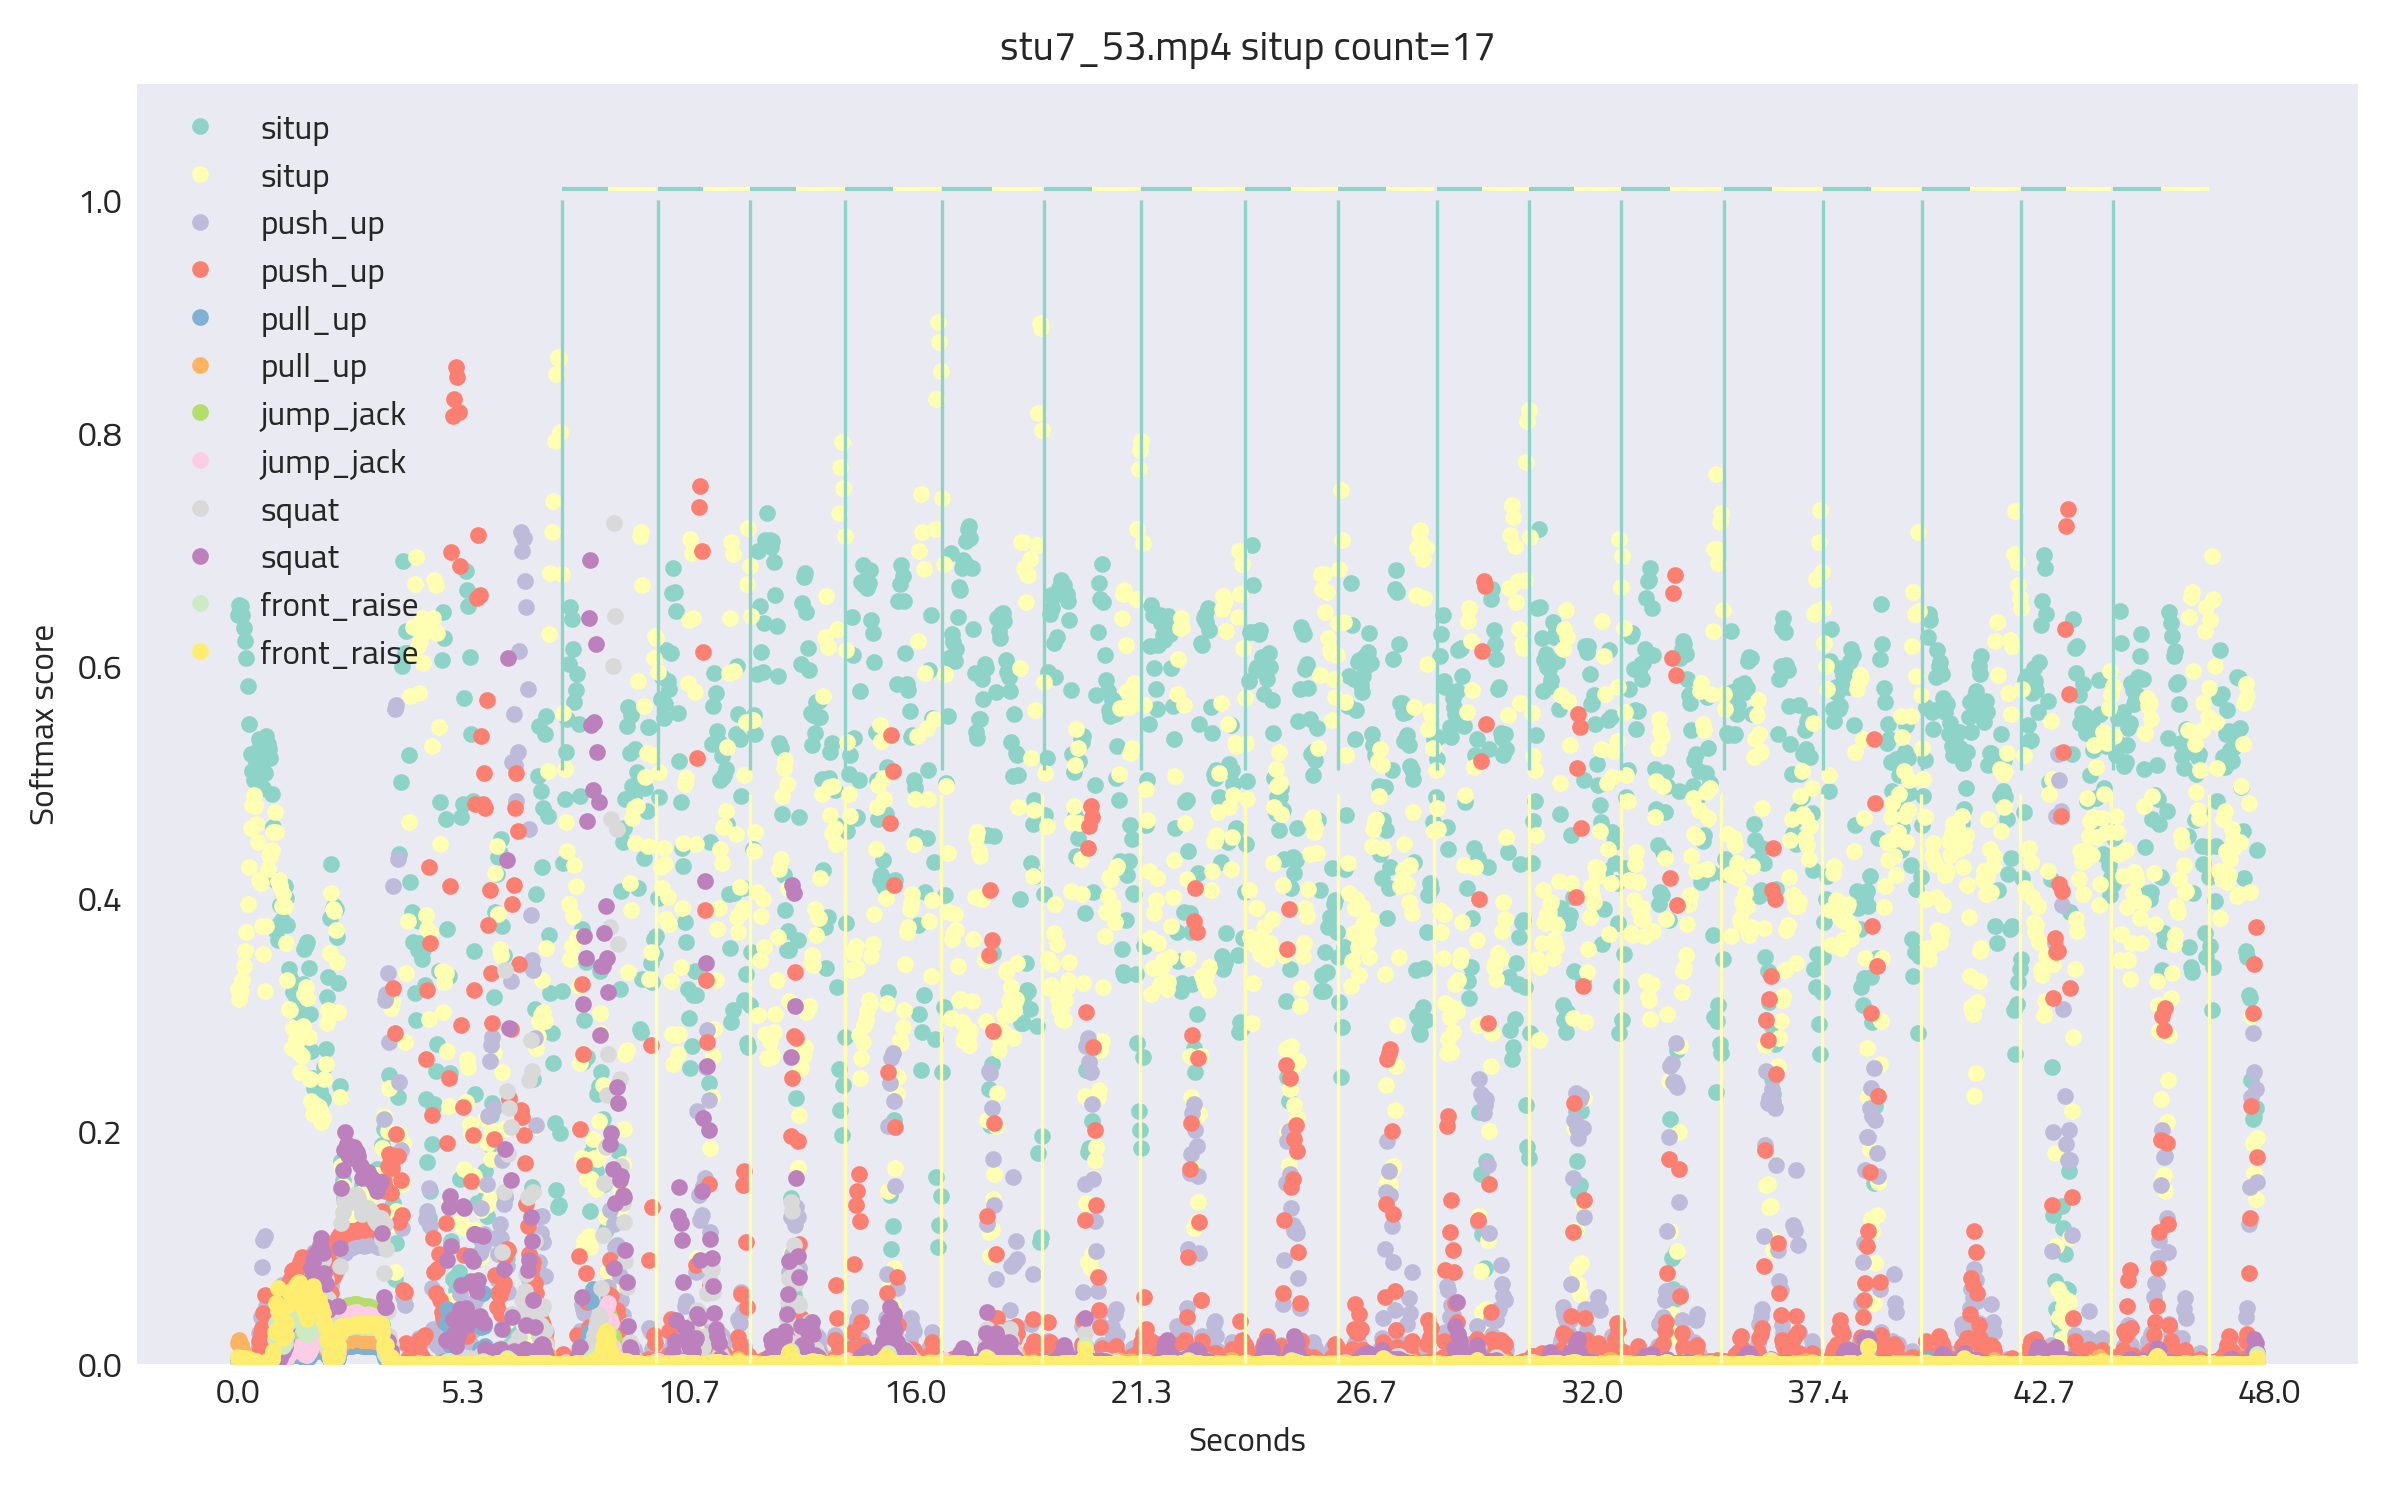

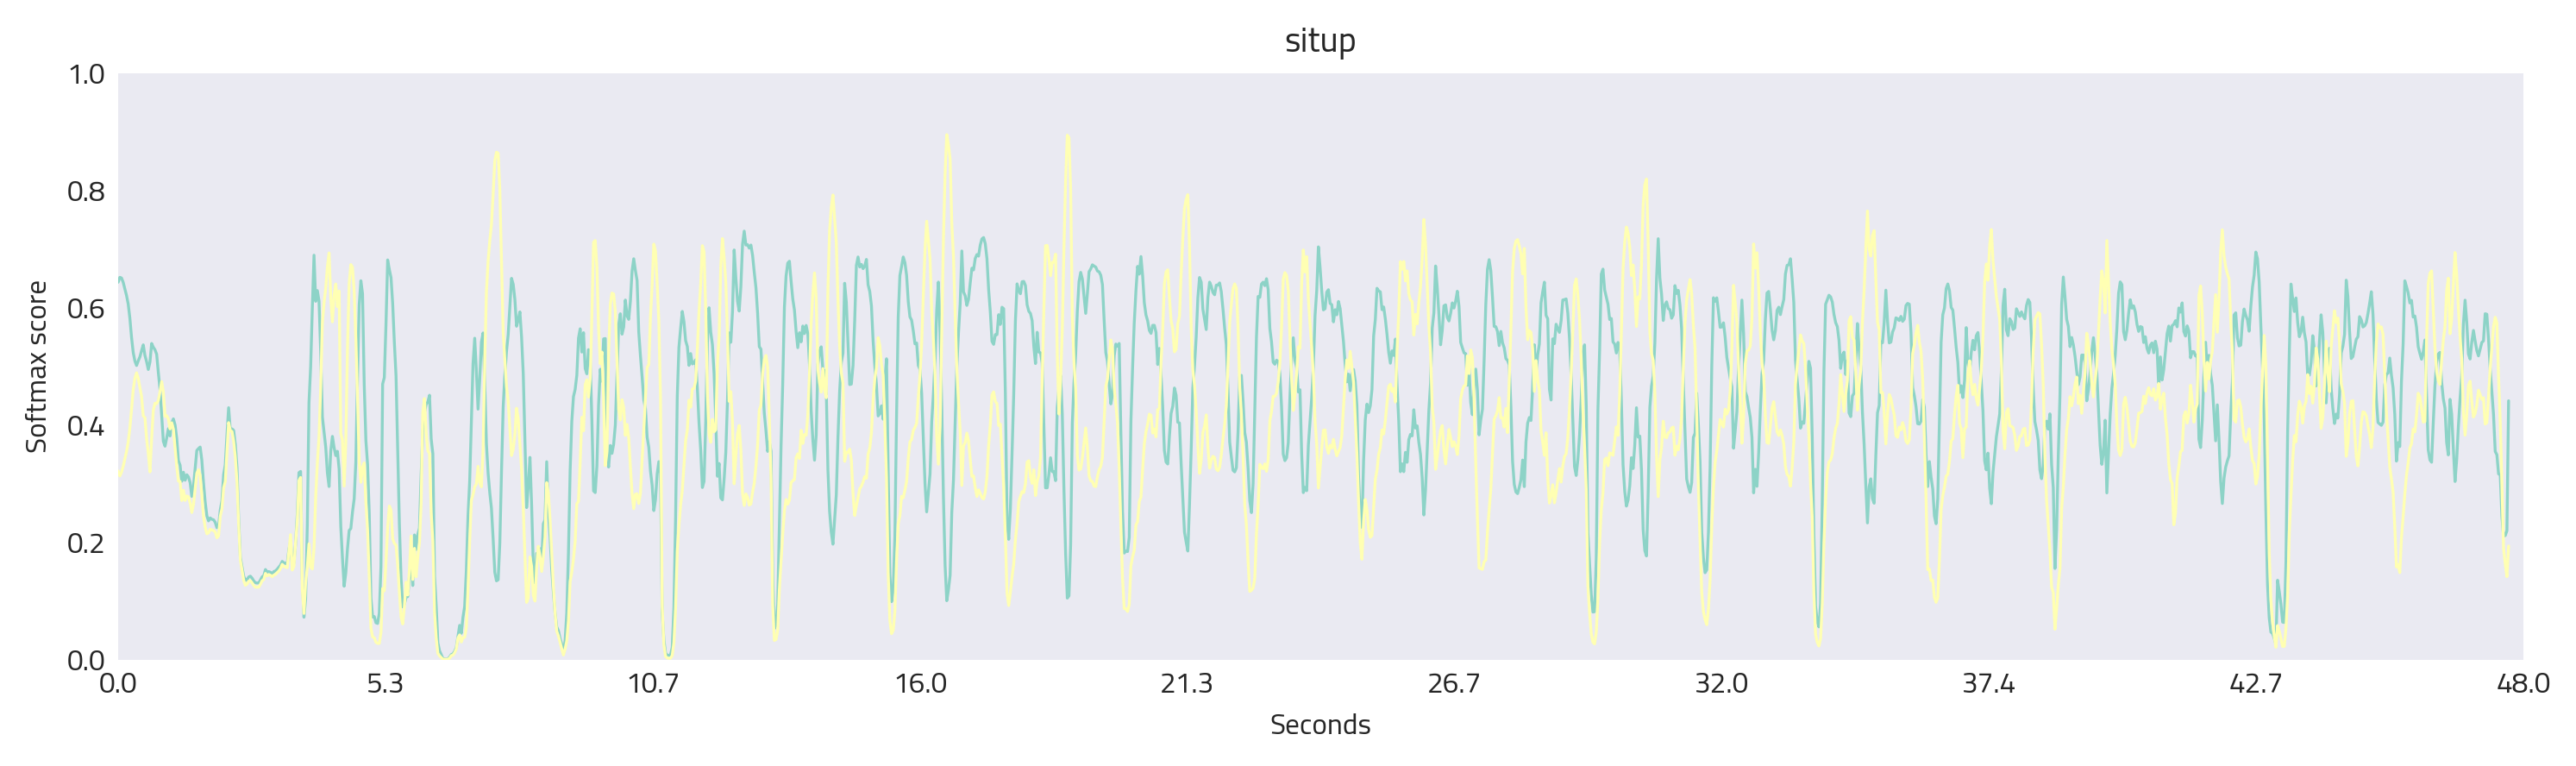

In [4]:
js = json.load(open(osj(json_dir, template.format(item.video_name))))

plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: a sequence of probabilities of shape (seq_len, 12)
- Output: a integer state

In [5]:
from hmmlearn import hmm
from workoutdetector.datasets import FeatureDataset
from workoutdetector.utils import pred_to_count
from workoutdetector.time_series import reps_to_label
from torch.utils.data import DataLoader

In [15]:
def train(action):
    feat_ds = FeatureDataset(json_dir, anno_path, 'train', action, window=1, stride=1)
    # print(feat_ds.x.shape)
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x), dim=1).numpy()
    transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x, feat_ds.y)
    # print(transmat, pi, means, cov)
    model = hmm.GaussianHMM(n_components=13, n_iter=300, covariance_type='diag')
    model.transmat_ = transmat
    model.startprob_ = pi.T
    model.means_ = means
    model.covars_ = cov
    softmax_x = F.softmax(torch.from_numpy(feat_ds.x.squeeze(1)), dim=1)
    # model.fit(softmax_x.numpy())
    return model


def hmm_infer(model, x, gt_reps, class_idx):
    gt_labels = reps_to_label(gt_reps, len(x), class_idx)
    y = model.predict(x)
    acc = (y == gt_labels[:len(y)]).sum() / len(gt_labels)
    gt_count = len(gt_reps) // 2
    count, reps = pred_to_count(y-1, stride=1, step=1) # minus 1 because no-class is 0
    diff = abs(count - gt_count)
    obo = 1 if (diff <= 1) else 0
    return obo, diff, acc,  reps

action = 'all'
model = train(action)

### Predict

(292, 12) [0 0 0 3 3 3 3 3 3 3]
count 5 name train2748.mp4 push_up
pred count 12
obo=0 err=7 acc=0.4212328767123288


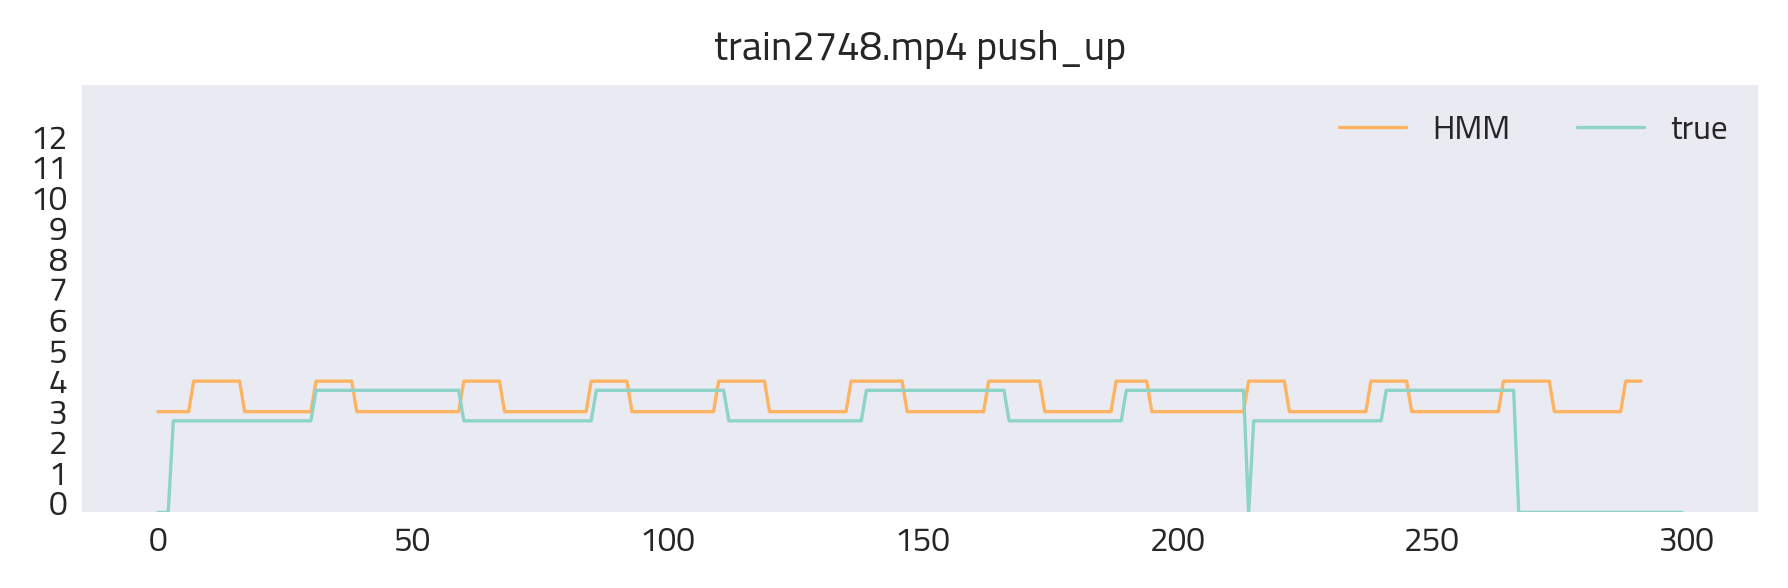

In [40]:
val_data = list(helper.get_rep_data(['val'], [action]).values())
item = random.choice(val_data)

val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
val_y = np.array(reps_to_label(item.reps, item.total_frames, class_idx=CLASSES.index(item.class_)))
print(val_x.shape, val_y[:10])

pred = model.predict(val_x)
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)

obo, err, acc, reps = hmm_infer(model, val_x, item.reps, CLASSES.index(item.class_))
print('pred count', len(reps) // 2)
print(f'obo={obo} err={err} acc={acc}')
fig= plt.figure(figsize=(6,2), dpi=300)
plt.tight_layout()
plt.plot(pred, 'C5', label='HMM')
plt.plot(val_y-0.3, 'C0', label='true')
# plt.plot(reps_to_label(reps, item.total_frames), 'C1', label='reps')
plt.yticks(range(13))
plt.ylim(-0.3, 13.7)
plt.legend(ncol=2)
plt.title(f'{item.video_name} {item.class_}')
plt.show()

### Eval

In [ ]:
def eval_subset(model, split, action):
    test_data = list(helper.get_rep_data([split], [action]).values())
    total_obo, total_err, total_acc = 0, 0, 0
    for item in test_data:
        test_x = []
        js = json.load(open(osj(json_dir, template.format(item.video_name))))
        for i,v in js['scores'].items():
            test_x.append(np.array(list(v.values())))
        test_x = np.array(test_x)

        pred = model.predict(test_x)
        obo, err, acc, reps = hmm_infer(model, test_x, item.reps)
        total_obo += obo
        total_err += err
        total_acc += acc

    obo_rate = total_obo / len(test_data)
    err_rate = total_err / len(test_data)
    acc_rate = total_acc / len(test_data)
    return dict(split=split, action=action, obo=obo_rate, mae=err_rate, hmm_acc=acc_rate)

result = []
for action in CLASSES:
    model = train(action)
    for split in ['train', 'val', 'test']:
        result.append(eval_subset(model, split, action))

df = pd.DataFrame(result)
df.to_csv('hmm_result.csv')
print(df.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
split &      action &      obo &       mae &  hmm\_acc \\
\midrule
train &       situp & 0.159574 &  9.255319 & 0.378971 \\
  val &       situp & 0.222222 &  9.722222 & 0.428948 \\
 test &       situp & 0.100000 & 11.000000 & 0.433482 \\
train &     push\_up & 0.172414 &  8.827586 & 0.519052 \\
  val &     push\_up & 0.277778 &  8.000000 & 0.531171 \\
 test &     push\_up & 0.062500 &  9.562500 & 0.511787 \\
train &     pull\_up & 0.223404 &  6.010638 & 0.500284 \\
  val &     pull\_up & 0.142857 &  6.071429 & 0.582846 \\
 test &     pull\_up & 0.526316 &  3.578947 & 0.554533 \\
train &   jump\_jack & 0.394737 & 10.618421 & 0.545389 \\
  val &   jump\_jack & 0.533333 &  3.800000 & 0.648088 \\
 test &   jump\_jack & 0.384615 &  9.307692 & 0.608489 \\
train &       squat & 0.326733 &  4.287129 & 0.517694 \\
  val &       squat & 0.375000 &  4.000000 & 0.540361 \\
 test &       squat & 0.411765 &  2.470588 & 0.558124 \\
train & front\_raise & 0.344086 &  3.

## LSTM Visualization

In [ ]:
x = np.load('../exp/time_series/acc_0.598_epoch_000-v1.ckpt.npy', allow_pickle=True)
print(len(x))
print(x[0].keys())

NameError: name 'np' is not defined